In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
manga_data = tf.keras.utils.image_dataset_from_directory("archive", image_size=(460, 660))

Found 31771 files belonging to 1 classes.


In [3]:
manga_data_iterator = manga_data.as_numpy_iterator()

In [4]:
manga_batch = manga_data_iterator.next()

In [5]:
print(manga_batch[0].shape)

(32, 460, 660, 3)


In [6]:
photo_data = tf.keras.utils.image_dataset_from_directory("archive2", image_size=(460, 660))
photo_data_iterator = photo_data.as_numpy_iterator()

Found 31783 files belonging to 1 classes.


In [7]:
photo_batch = photo_data_iterator.next()

In [8]:
photo_batch[0].shape

(32, 460, 660, 3)

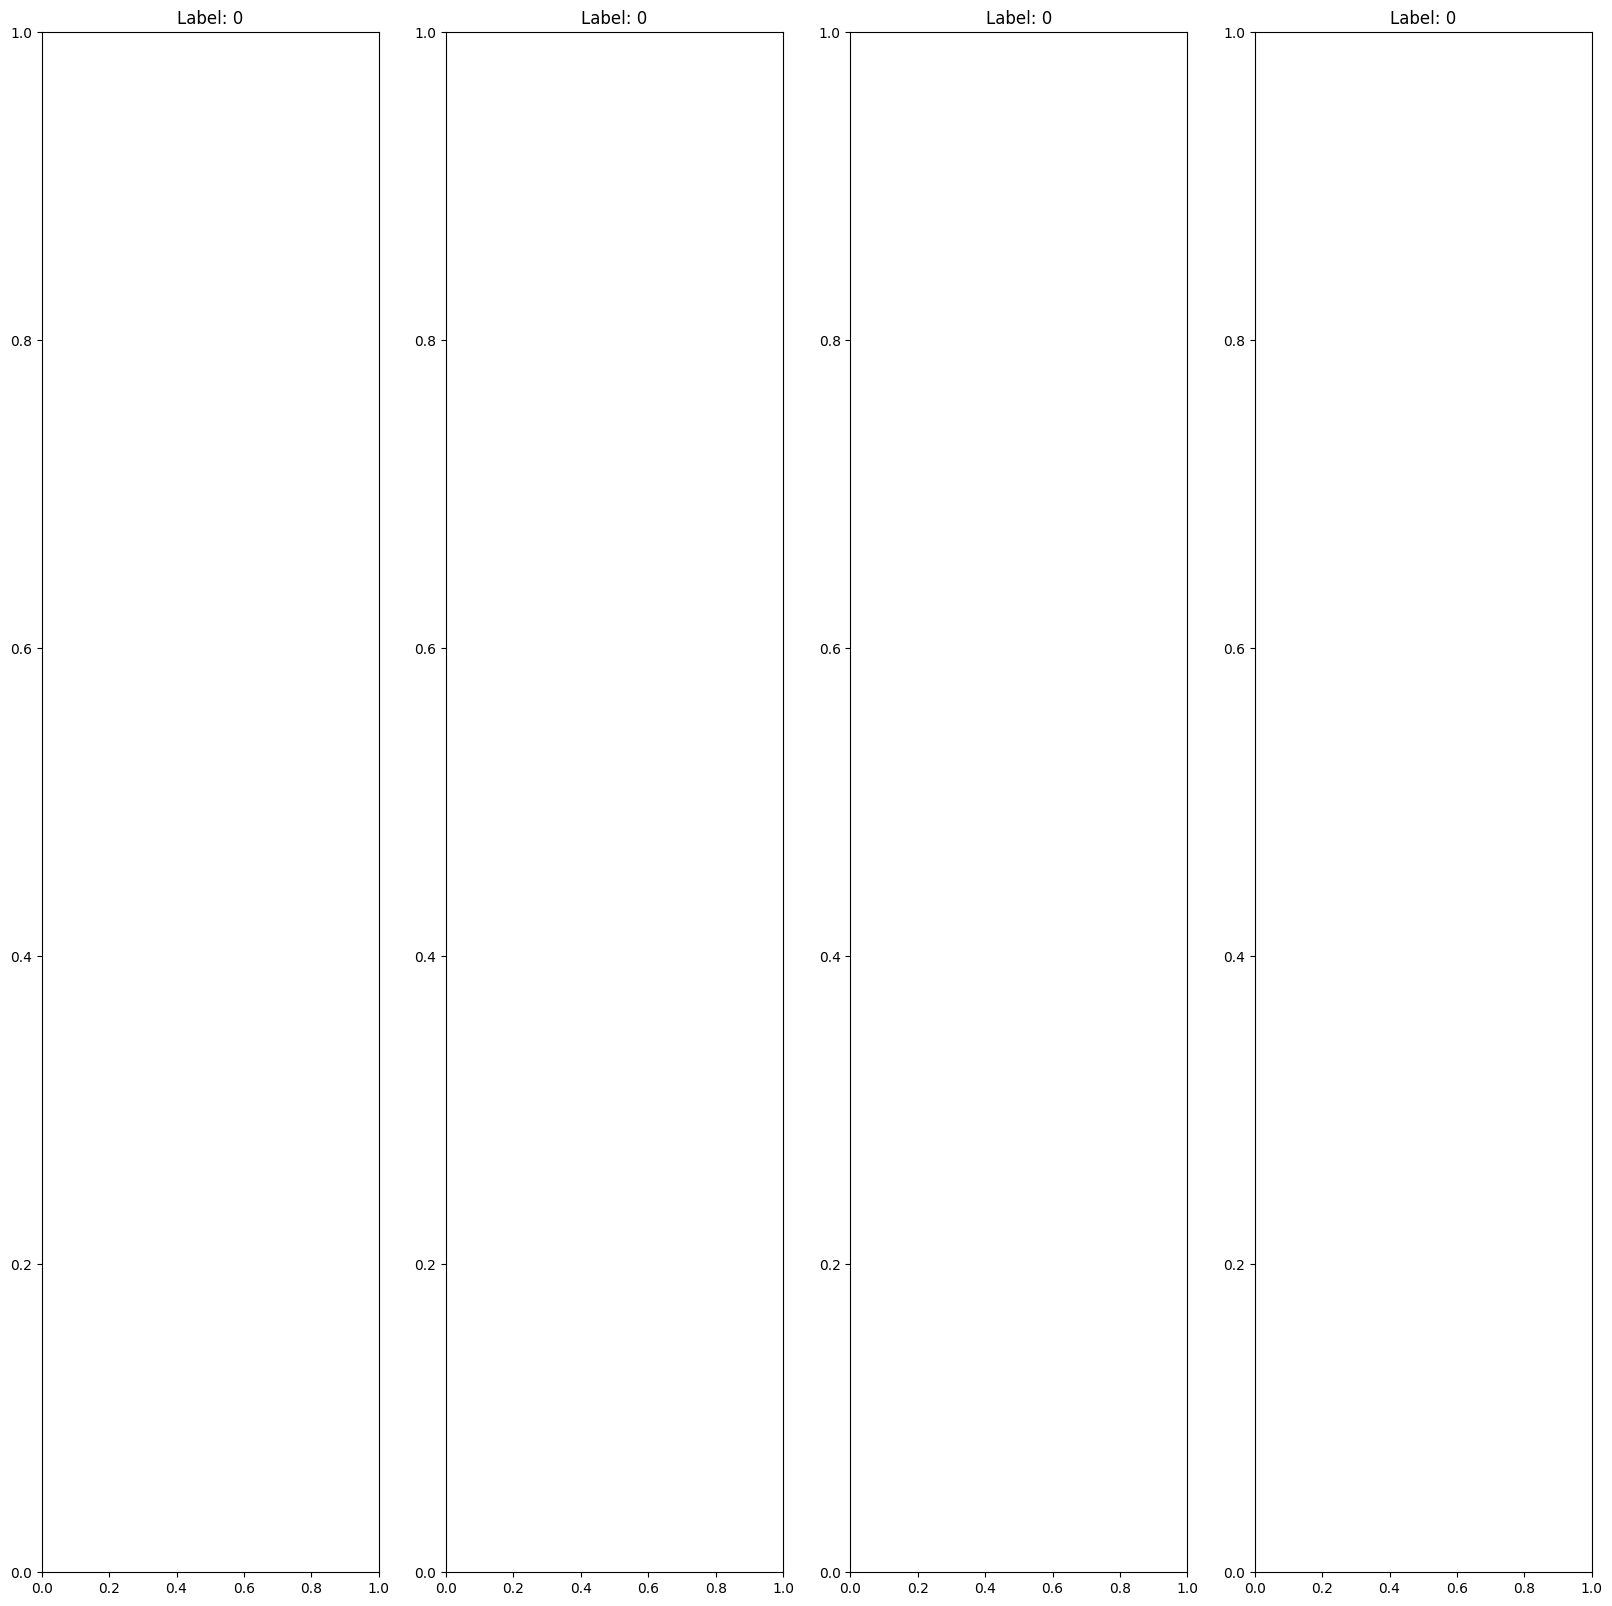

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(photo_batch[0][:4]):
    # ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {photo_batch[1][idx]}")

## Preprocess

In [10]:
# normalizing the photos and manga data
manga_data = manga_data.map(lambda x,y: (x/255, y))
photo_data = photo_data.map(lambda x,y: (x/255, y))

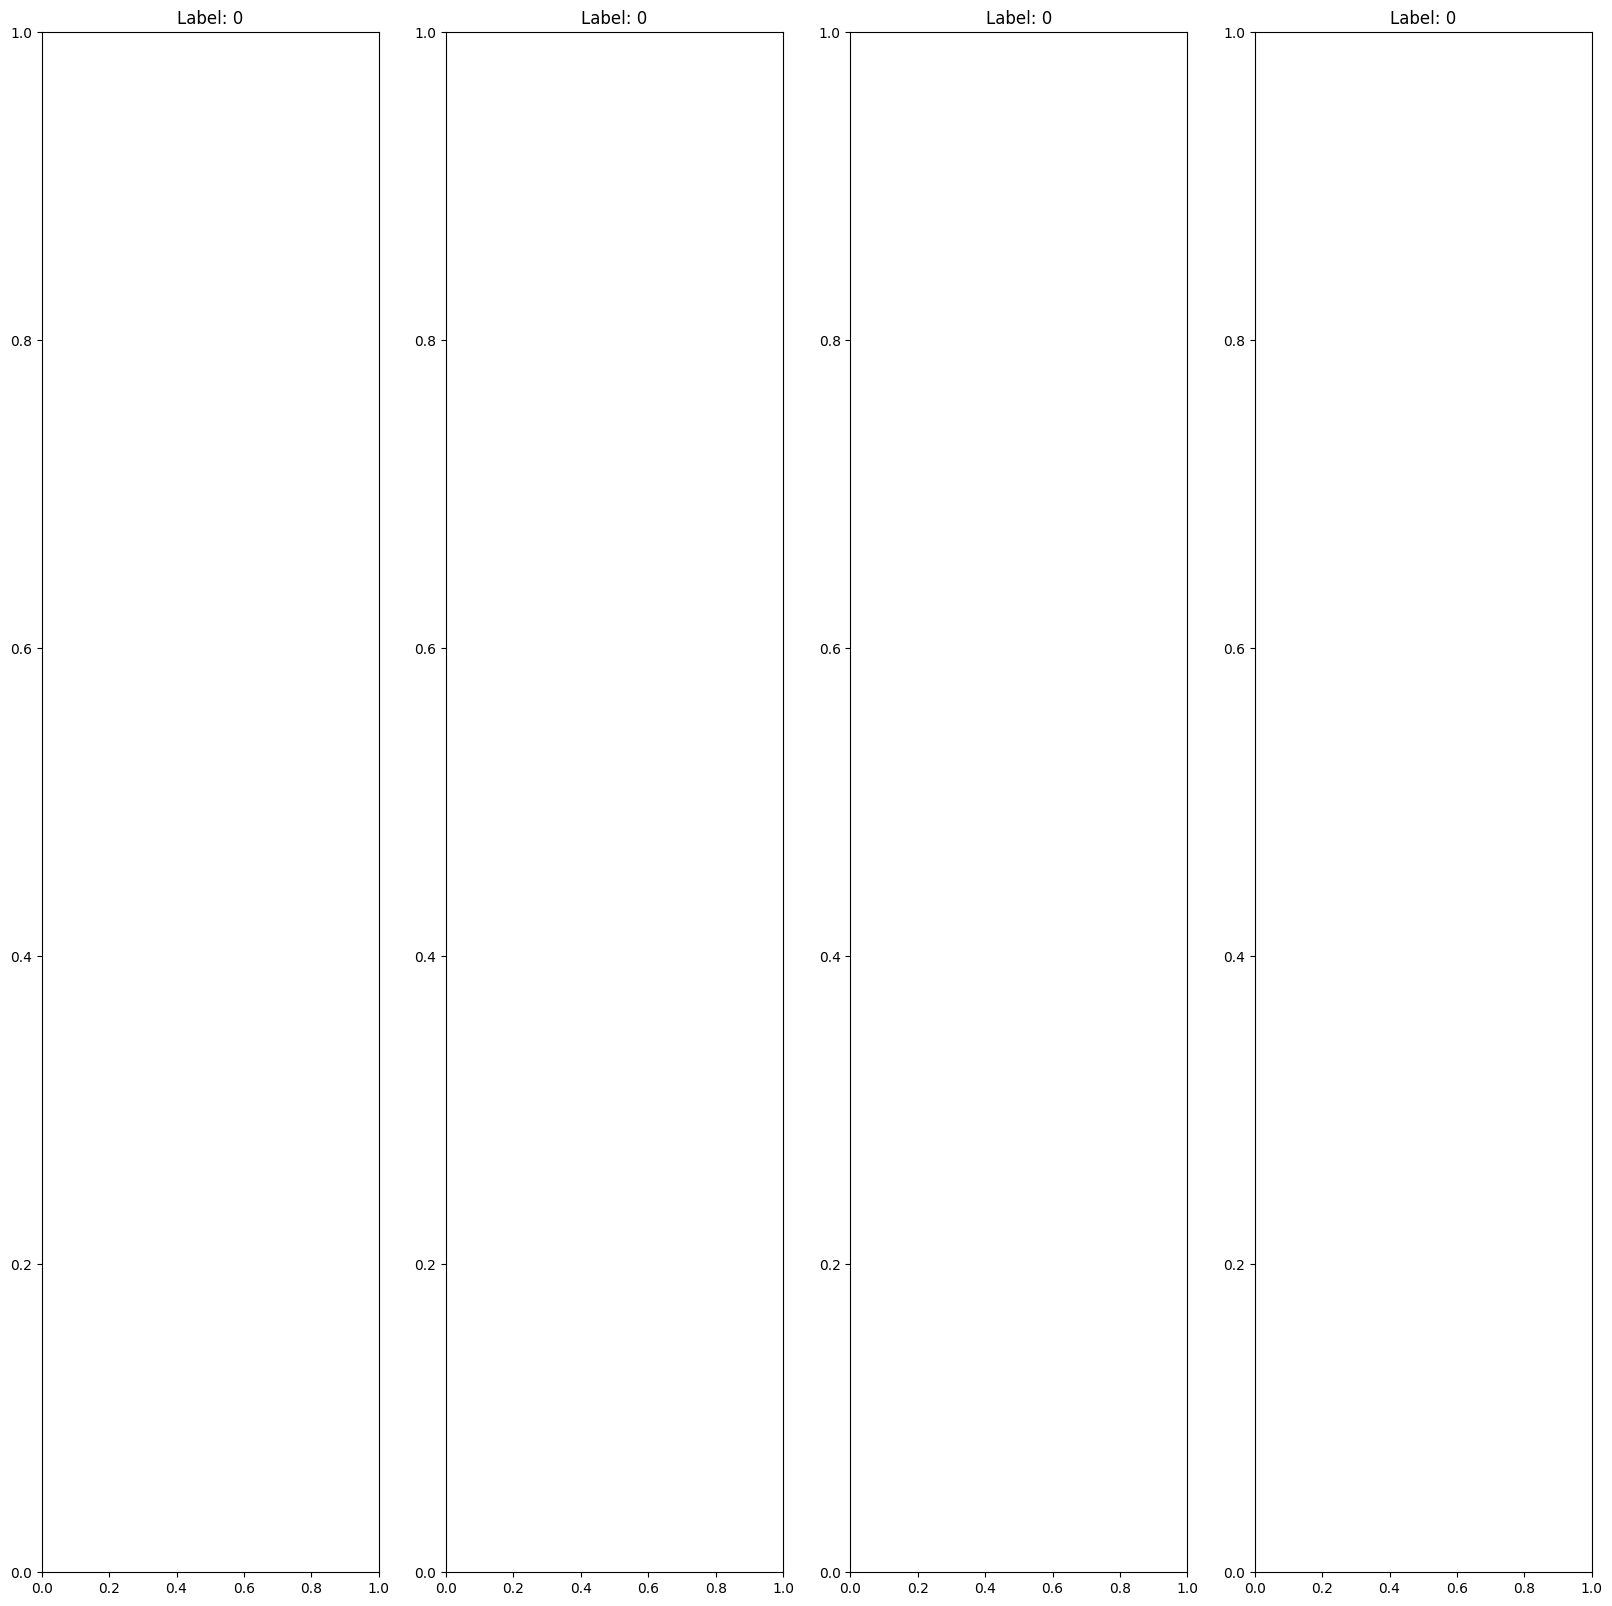

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(manga_batch[0][:4]):
    # ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {manga_batch[1][idx]}")

## Discriminator

In [12]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=[460, 660, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
D = make_discriminator()
D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 330, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 230, 330, 128)     0         
                                                                 
 dropout (Dropout)           (None, 230, 330, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 165, 128)     147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 115, 165, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 115, 165, 128)     0         
                                                                 
 flatten (Flatten)           (None, 2428800)           0

In [14]:
#create generator with the output size as the input size of the discriminator
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128 * 115 * 165, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((115, 165, 128)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(3, (7, 7), activation='sigmoid', padding='same'))
    return model

In [15]:
G = make_generator()
G.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2428800)           245308800 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2428800)           0         
                                                                 
 reshape (Reshape)           (None, 115, 165, 128)     0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 230, 330, 128)     262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 230, 330, 128)     0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 460, 660, 128)     262272    
 Transpose)                                           

In [16]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [17]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset[0].shape[0], n_samples)
    X = dataset[0]
    y = np.ones((n_samples, 1))
    return X, y
    # return 1, 0

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    batch_per_epoch = len(dataset)
    half_batch = int(n_batch / 2)
    data_itr = dataset.as_numpy_iterator()
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(data_itr.next(), half_batch)
            print("hi")
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            print("hi2")
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            print("hi3")
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            print("hi4")

            X_gan = generate_latent_points(latent_dim, n_batch)
            print("hi5")
            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print("hi6")

            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f', (i + 1), (j + 1), batch_per_epoch, d_loss1, d_loss2, g_loss)
            
            g_model.save('generator.h5')

In [19]:
train(G, D, define_gan(G, D), manga_data, 100, 64)

hi
hi2
1/1 [==============================] - 87s 87s/step
hi3
hi4
hi5
